In [81]:
import numpy as np
from copy import deepcopy as copy
import tqdm
import networkx as nx
import numba
from numba import njit, prange, jit
%config Completer.use_jedi = False
import multiprocessing as mp
import matplotlib.pyplot as plt



# %%
@numba.jit(nopython=True)
def relu(x):
    return max(x, 0)

@numba.jit(nopython=True)
def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

@numba.jit(nopython=True)
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

class NodeGene:
    def __init__(self, id, type, h=0, bias=np.random.uniform(-1, 1)):
        self.h = h
        self.type = type
        self.id = id
        self.bias = bias


class ConnectionGene:
    def __init__(self, inputNode, outputNode, weight, innovation, enabled=True):
        self.enabled = enabled
        self.innovation = innovation
        self.weight = weight
        self.outputNode = outputNode
        self.inputNode = inputNode


class Specimen:
    # generating Phenotype from Genotype

    def __init__(self, input_, output, protection = 3):
        self.id_of_next = output + input_

        inputs = [NodeGene(i, 'input') for i in range(input_)]
        outputs = [NodeGene(i + len(inputs), 'output', h=1) for i in range(output)]

        self.nodes = inputs + outputs
        self.protection = protection
        self.connections = []
        innovation = 0
        for i in range(input_):
            for j in range(input_, input_ + output):
                self.connections.append(ConnectionGene(i, j, np.random.normal(0, 1), innovation))
                innovation += 1

    def create_new(self):
        new_specimen = copy(self)
        new_specimen.protection = 3
        return new_specimen

    def forward(self, input_):

        order = [node.h for node in self.nodes]
        output = np.array([None]* (len(self.nodes) - len(input_)))
        order = np.argsort(order)
        values = [0] * len(self.nodes)
        values = np.array(values).astype('float32')
        # now we are sending the signal
        for i, node in enumerate([self.nodes[i] for i in order]):
            if node.h == 0:
                values[node.id] = input_[node.id]
                for connection in self.connections:
                    if connection.inputNode == node.id:
                        values[connection.outputNode] += relu(values[node.id] * connection.weight + node.bias)

            elif node.h > 0 and node.h < 1:

                for connection in self.connections:
                    values[connection.outputNode] += relu(values[node.id] * connection.weight + node.bias)

            elif node.h == 1:
                # this is output neuron
                output[node.id - len(input_)] = values[node.id]

        return output
    


    def return_with_mutated_weight(self, threshold=0.8):
        new = copy(self)
        for connection in new.connections:
            if np.random.uniform(0, 1) < threshold:
                connection.weight *= np.random.uniform(-2.5, 2.5)
            else:
                connection.weight = np.random.normal(0, 1)

        return new

    def return_with_mutated_bias(self, threshold=0.8):
        new = copy(self)
        for node in new.nodes:
            if np.random.uniform(0, 1) < threshold:
                node.bias *= np.random.uniform(-2.5, 2.5)
            else:
                node.bias = np.random.normal(0, 1)
        return new

    def accuracy(self, x, y):

        res = []
        for inp in x:
            res.append(np.argmax(softmax(self.forward(inp).astype('float32'))))

        return ((res == y) * 1).mean()

    def mae(self, x, y):
        res = []
        for inp in x:
            res.append(self.forward(inp))

        return np.abs(x - y).mean()

def forward_async(i, specimen:Specimen, input_):

    order = [node.h for node in specimen.nodes]
    output = np.array([None]* (len(specimen.nodes) - len(input_)))
    order = np.argsort(order)
    values = [0] * len(specimen.nodes)
    values = np.array(values).astype('float32')
    # now we are sending the signal
    for i, node in enumerate([specimen.nodes[i] for i in order]):
        if node.h == 0:
            values[node.id] = input_[node.id]
            for connection in specimen.connections:
                if connection.inputNode == node.id:
                    values[connection.outputNode] += relu(values[node.id] * connection.weight + node.bias)

        elif node.h > 0 and node.h < 1:

            for connection in self.connections:
                values[connection.outputNode] += relu(values[node.id] * connection.weight + node.bias)

        elif node.h == 1:
            # this is output neuron
            output[node.id - len(input_)] = values[node.id]

    return (i, output)    
    
 
    
def global_accuracy(specimen:Specimen, x,y):
        
        pool = mp.Pool(mp.cpu_count())
        results = []
        
        def get_results(result):
            global results
            results.append(result)   

        print('went into the thread')
        for i, inp in enumerate(x):
            pool.apply_async(forward_async, args=(i, specimen, inp), callback = get_results)

        
        pool.close()
        pool.join()
        
        results.sort(key=lambda x: x[0])
        results_final = [r for i, r in results]
        print('thread ended!')
        

        results_final= np.argmax(softmax(results_final.astype('float32')))
            
        return ((results_final == y) * 1).mean()

class NEAT:

    def __init__(self, population_number, input_, output):
        self.population_number = population_number
        self.input = input_
        self.output = output
        self.innovation = input_ * output
        self.connection_innovations = []
        self.gen_mean = []

    def start(self):
        # initialize the population
        self.population = [Specimen(self.input, self.output) for i in range(self.population_number)]

    def calculate_innovation(self, connection_innovation):

        for nodes in self.connection_innovations:
            if nodes[0] == connection_innovation:
                k = nodes[1]
                return [k, k + 1]

        # if there was no innovation like this before, than:
        self.connection_innovations.append([connection_innovation, self.innovation])
        p = self.innovation
        self.innovation += 2

        return [p, p + 1]

    def add_connection(self, network):
        new_network = copy(network)
        a, b = np.random.choice(network.nodes, 2, replace=False)
        does_exist = False

        # first search for connection in genes
        for connection in new_network.connections:
            if a.id == connection.inputNode and b.id == connection.outputNode:
                does_exist = True
        if a.type != b.type:
            if not does_exist:
                if a.h < b.h:
                    new_network.connections.append(
                        ConnectionGene(a.id, b.id, np.random.normal(0, 1.5), self.innovation))
                else:
                    new_network.connections.append(
                        ConnectionGene(b.id, a.id, np.random.normal(0, 1.5), self.innovation))
                self.innovation += 1
        return new_network

    @staticmethod
    def find_connection_by_innovation(specimen, innovation):
        for connection in specimen.connections:
            if connection.innovation == innovation:
                return connection

    def cross(self, a, b):

        child = Specimen(0,0)
        if len(a.nodes) > len(b.nodes):
            child.nodes = a.nodes
        else :
            child.nodes = b.nodes

        a_innovations = [x.innovation for x in a.connections]
        b_innovations = [x.innovation for x in b.connections]

        for innovation_number in range(max(a_innovations) + max(b_innovations) + 1):
            if innovation_number in a_innovations:
                if innovation_number in b_innovations:
                    if np.random.uniform(0,1) > 0.5:
                        new_connection = copy(self.find_connection_by_innovation(a, innovation_number))
                    else :
                        new_connection = copy(self.find_connection_by_innovation(b, innovation_number))

                    child.connections.append(new_connection)
                else:
                    new_connection = copy(self.find_connection_by_innovation(a, innovation_number))
                    child.connections.append(new_connection)
            else:
                if innovation_number in b_innovations:
                    new_connection = copy(self.find_connection_by_innovation(b, innovation_number))
                    child.connections.append(new_connection)

        return child

    def add_node(self, network):
        new_network = copy(network)
        a = new_network.connections[np.random.choice(len(new_network.connections), 1)[0]]
        if a.enabled:

            a.enabled = False
            higher_node_id = new_network.id_of_next
            new_network.id_of_next += 1

            height_input = new_network.nodes[a.inputNode].h
            height_output = new_network.nodes[a.outputNode].h
            h = np.random.uniform(0.7 * height_input + 0.3 * height_output, 0.3 * height_input + 0.7 * height_output)
            new_network.nodes.append(NodeGene(higher_node_id, 'hidden', h=h))
            innovation = self.calculate_innovation(a.innovation)

            new_network.connections.append(
                ConnectionGene(a.inputNode, higher_node_id, np.random.uniform(-1, 1), innovation[0]))
            new_network.connections.append(
                ConnectionGene(higher_node_id, a.outputNode, np.random.uniform(-1, 1), innovation[1]))
            return new_network
        else:
            return network

    def start_evolution(self, x, y, epochs=50, to_mutate=0.7, measure='acc'):
        best_specimen = None
        for i in range(epochs):
            nodes_to_mutate = np.random.choice(self.population_number, int(np.ceil(self.population_number * to_mutate)))
            nodes_to_mutate = [self.population[i].create_new() for i in nodes_to_mutate]
            spec_with_mutated_node = [self.add_node(specimen) for specimen in nodes_to_mutate]
            connection_to_mutate = np.random.choice(self.population_number, int(np.ceil(self.population_number * to_mutate)))
            connection_to_mutate = [self.population[i].create_new() for i in connection_to_mutate]
            spec_with_mutated_connection = [self.add_connection(specimen) for specimen in connection_to_mutate]
            weight_to_mutate = np.random.choice(self.population_number, int(np.ceil(self.population_number * to_mutate)))
            weight_to_mutate = [self.population[i].create_new() for i in weight_to_mutate]
            spec_with_mutated_weight = [specimen.return_with_mutated_weight() for specimen in weight_to_mutate]
            bias_to_mutate = np.random.choice(self.population_number, int(np.ceil(self.population_number * to_mutate)))
            bias_to_mutate = [self.population[i].create_new() for i in bias_to_mutate]
            spec_with_mutated_bias = [specimen.return_with_mutated_bias() for specimen in bias_to_mutate]

            to_cross = np.random.choice(self.population_number, int(np.ceil(self.population_number * to_mutate)), replace=False)
            spec_crossed = []
            for j in range(0, len(to_cross)-1, 2):
                spec_crossed.append(self.cross(self.population[to_cross[j]], self.population[to_cross[j + 1]]))

            new_population = self.population + spec_with_mutated_node + spec_with_mutated_connection + spec_with_mutated_weight + spec_with_mutated_bias + spec_crossed
            
            if measure == 'acc':
                metrics_for_new_population = [global_accuracy(specimen, x, y) for specimen in new_population]
            else: 
                metrics_for_new_population = [-specimen.mae(x, y) for specimen in new_population]
            
            best_ = np.argsort(metrics_for_new_population)
            best = best_[-self.population_number:]

            for spec in new_population:
                if spec.protection > 0:
                    self.population.append(spec)

            for j, spec in enumerate(self.population):
                spec.protection -= 1
                self.population[j] = spec

            self.population = list(np.array(new_population)[best])
            
            if measure == 'acc':
                self.gen_mean.append(np.mean([specimen.accuracy(x, y) for specimen in self.population]))
                print(f'iteration: {i}/{epochs}\nPopulation mean: {self.gen_mean[-1]} \nPopulation best: {np.max(metrics_for_new_population)}\n', end='')

            else: 
                self.gen_mean.append(np.mean([specimen.mae(x, y) for specimen in self.population]))
                print(f'iteration: {i}/{epochs}\nPopulation mean: {self.gen_mean[-1]} \nPopulation best: {-np.max(metrics_for_new_population)}\n', end='')

            
            
        metrics_for_new_population = [specimen.accuracy(x,y) for specimen in self.population]
        best = np.argsort(metrics_for_new_population)
        self.best = self.population[best[-1]]


In [ ]:
from multiprocessing import Pool
from os import getpid

def double(i):
    print("I'm process", getpid())
    return i * 2

if __name__ == '__main__':
    with Pool() as pool:
        result = pool.map(double, [1, 2, 3, 4, 5])
        print(result)

In [2]:
%%timeit

import numpy as np
from time import time

# Prepare data
np.random.RandomState(100)
arr = np.random.randint(0, 10, size=[200000, 5])
data = arr.tolist()
data[:5]

def howmany_within_range(row, minimum, maximum):
    """Returns how many numbers lie within `maximum` and `minimum` in a given `row`"""
    count = 0
    for n in row:
        if minimum <= n <= maximum:
            count = count + 1
    return count

results = []
for row in data:
    results.append(howmany_within_range(row, minimum=4, maximum=8))

print(results[:10])

[1, 3, 3, 2, 3, 2, 2, 3, 2, 2]
[3, 3, 3, 2, 4, 4, 5, 3, 3, 4]
[4, 2, 2, 2, 2, 2, 3, 2, 4, 2]
[3, 1, 4, 4, 2, 2, 3, 0, 4, 2]
[0, 5, 3, 3, 1, 2, 3, 3, 3, 3]
[2, 2, 2, 3, 3, 1, 3, 4, 2, 3]
[3, 3, 3, 2, 2, 5, 2, 2, 5, 3]
[4, 3, 1, 2, 5, 1, 2, 2, 2, 3]
148 ms ± 5.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:


import multiprocessing as mp
pool = mp.Pool(mp.cpu_count())

results = []

# Step 1: Redefine, to accept `i`, the iteration number
def howmany_within_range2(i, row, minimum, maximum):
    """Returns how many numbers lie within `maximum` and `minimum` in a given `row`"""
    count = 0
    for n in row:
        if minimum <= n <= maximum:
            count = count + 1
    return (i, count)


# Step 2: Define callback function to collect the output in `results`
def collect_result(result):
    global results
    results.append(result)


# Step 3: Use loop to parallelize
for i, row in enumerate(data):
    pool.apply_async(howmany_within_range2, args=(i, row, 4, 8), callback=collect_result)

# Step 4: Close Pool and let all the processes complete    
pool.close()
pool.join()  # postpones the execution of next line of code until all processes in the queue are done.

# Step 5: Sort results [OPTIONAL]
results.sort(key=lambda x: x[0])
results_final = [r for i, r in results]

print(results_final[:10])
#> [3, 1, 4, 4, 4, 2, 1, 1, 3, 3]

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder

In [4]:
train_df = pd.read_csv('../data/iris.data', header=None, index_col=0).reset_index()

x = np.asarray(train_df.iloc[:,0:4])
x = (x - np.mean(x, axis = 0))/np.std(x, axis = 0)

y = np.asarray(train_df.iloc[:,4]).reshape(-1, 1)
y = OrdinalEncoder().fit_transform(y).astype('int').flatten()


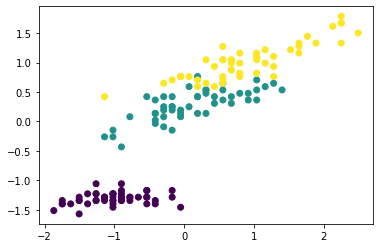

In [5]:
plt.scatter(x[:,0], x[:,2], c=y)
plt.show()

In [ ]:
neat = NEAT(100, 4, 3)
neat.start()
neat.start_evolution(x[:10], y[:10], epochs=40)

went into the thread


Text(0, 0.5, 'mean accuracy of population')

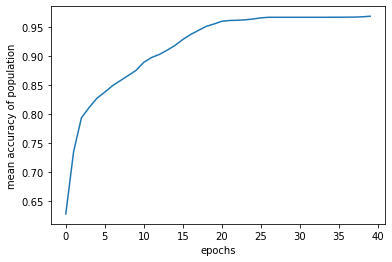

In [18]:
plt.plot(neat.gen_mean)
plt.xlabel('epochs')
plt.ylabel('mean accuracy of population')

In [19]:
ids = [neat.best.nodes[i].id for i in range(len(neat.best.nodes))]

In [20]:
cons = [(neat.best.connections[i].inputNode, neat.best.connections[i].outputNode) for i in range(len(neat.best.connections))]

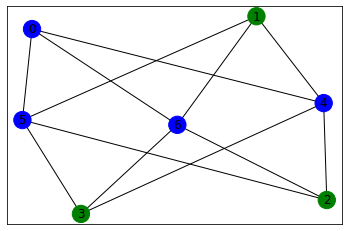

In [21]:
G = nx.Graph()
G.add_edges_from(cons)
color_map = []
for i, node in enumerate(G):
    if neat.best.nodes[i].type == 'input':
        color_map.append('blue')
    elif  neat.best.nodes[i].type == 'output':
        color_map.append('green')
    else: 
        color_map.append('red')
nx.draw_networkx(G, node_color= color_map)

In [25]:
adult = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)

In [26]:
adult

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

categorical_features = [7 ,8, 9]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_features = [0, 2,4,10,11,12]
numerical_transformer = Pipeline(steps=[
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
])

X = preprocessor.fit_transform(adult)

In [39]:
X.shape

(32561, 19)

In [45]:
y = OrdinalEncoder().fit_transform(np.array(adult[14]).reshape(-1,1))

In [52]:
neat = NEAT(100, 19, 2)
neat.start()
neat.start_evolution(X[:1000, :], y[:1000].flatten(), epochs=40)

iteration: 0/40
Population mean: 0.7574699999999999 
Population best: 0.768
iteration: 1/40
Population mean: 0.768 
Population best: 0.768
iteration: 2/40
Population mean: 0.768 
Population best: 0.768
iteration: 3/40
Population mean: 0.768 
Population best: 0.768
iteration: 4/40
Population mean: 0.768 
Population best: 0.768
iteration: 5/40
Population mean: 0.768 
Population best: 0.768
iteration: 6/40
Population mean: 0.768 
Population best: 0.768
iteration: 7/40
Population mean: 0.768 
Population best: 0.768


KeyboardInterrupt: 

In [7]:
import tensorflow as tf
data = tf.keras.datasets.mnist.load_data(path="mnist.npz")

In [54]:
x = data[0][0]
y = data[0][1]
x = x.reshape(x.shape[0], x.shape[1] * x.shape[2])

x5 = x[np.where(y == 5)[0]]
y5 = y[np.where(y == 5)[0]]
xnot5 = x[np.where(y != 5)[0]]
ynot5 = y[np.where(y != 5)[0]]

indices = np.random.choice(np.arange(len(xnot5)), x5.shape[0], replace=False, )
xnot5 = xnot5[indices]
ynot5 = ynot5[indices]

x = np.append(x5, xnot5, axis=0)
y = np.append(y5, ynot5)

indices = np.random.permutation(np.arange(len(x)))
x = x[indices]
y = y[indices]

y[y != 5] = 0
y[y == 5] = 1

x = x/ 255

In [84]:
@jit(parallel=True, forceobj=True)
def process_images(data: np.array):
    ret = []
    for i in prange(len(data)):
    
        mat = data[i].reshape(28,28)
        M, N = mat.shape
        K = 2
        L = 2

        MK = M // K
        NL = N // L
        p = mat[:MK*K, :NL*L].copy()
        p = p.reshape(MK, K, NL, L).copy()
        p = p.mean(axis=(1, 3)).copy()

        # once more
        mat = p
        M, N = mat.shape
        K = 2
        L = 2

        MK = M // K
        NL = N // L
        p = mat[:MK*K, :NL*L].reshape(MK, K, NL, L).max(axis=(1, 3))
        p = p[1:-1, 1:-1]

        ret.append(p.flatten())
    
    return np.array(ret)



In [75]:
neat = NEAT(10, 784, 2)
neat.start()
neat.start_evolution(x[:100, :], y[:100].flatten(), epochs=10)

iteration: 0/10
Population mean: 0.54 
Population best: 0.54
iteration: 1/10
Population mean: 0.54 
Population best: 0.54
iteration: 2/10
Population mean: 0.54 
Population best: 0.54
iteration: 3/10
Population mean: 0.54 
Population best: 0.54
iteration: 4/10
Population mean: 0.54 
Population best: 0.54
iteration: 5/10
Population mean: 0.54 
Population best: 0.54
iteration: 6/10
Population mean: 0.54 
Population best: 0.54
iteration: 7/10
Population mean: 0.54 
Population best: 0.54
iteration: 8/10
Population mean: 0.54 
Population best: 0.54
iteration: 9/10
Population mean: 0.54 
Population best: 0.54


In [76]:
x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [67]:
import pickle

with open('iris.pkl', 'rb') as FILE:
    neat = pickle.load(FILE)
    